In [1]:
import os
os.environ["OMP_NUM_THREADS"] = "1"
import sys
import copy
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
from matplotlib.colors import ListedColormap
import seaborn as sns
import geopandas as gpd
from ExKMC.Tree import Tree as ExTree
from ExKMC.splitters import get_min_mistakes_cut, get_min_surrogate_cut


sys.path.append("../main")
from tree import *
from rules import *
from tree_rules import *
from rule_clustering import *
from utils import *

%load_ext autoreload
%autoreload 2

In [2]:
# NOTE: The following is important for recreating results, 
# But can be changed for randomized analysis.
seed = 342
np.random.seed(seed)

In [116]:
plt.rcParams.update({
    "pgf.texsystem": "pdflatex",
    "font.family": "serif",
    "font.serif": [],
    "text.usetex": True,
    "pgf.rcfonts": False,
    "font.size": 14
})

colorblind_palette = sns.color_palette("colorblind", as_cmap=False)
cmap = ListedColormap(colorblind_palette)
subset_colors = [cmap(0), cmap(4), cmap(9)]
cmap_subset = ListedColormap(subset_colors)
#subset_colors2 = [cmap(0), cmap(2), cmap(5), cmap(4), cmap(8), cmap(9),]
subset_colors2 = [cmap(0), cmap(2), cmap(9), cmap(4), cmap(7), cmap(8),]
cmap_subset2 = ListedColormap(subset_colors2)

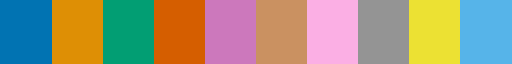

In [4]:
cmap

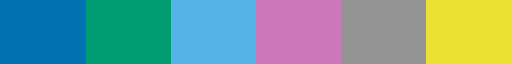

In [5]:
cmap_subset2

# Dataset

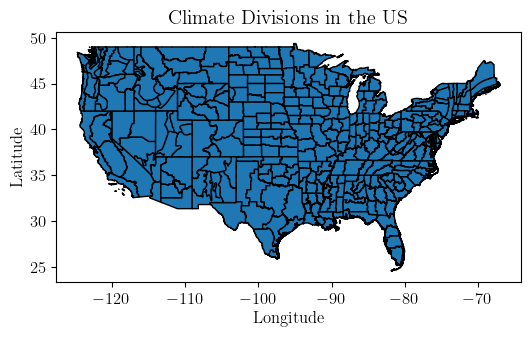

In [6]:
shapefile_path = '../data/climate_divisions/climate_divisions.shp'
dtype_dict = {'CLIMDIV': 'str'}
gdf = gpd.read_file(shapefile_path, dtype = dtype_dict)
gdf['CLIMDIV'] = gdf['CLIMDIV'].apply(lambda x: f'{int(x):04d}')

gdf.plot(figsize=(6, 6), edgecolor='black')
plt.title('Climate Divisions in the US')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

In [7]:
climate_data = pd.read_csv('../data/climate.csv', dtype={'ID': str, 'Year': str})
climate_data.set_index(['ID', 'Year'], inplace=True)

In [8]:
climate_data

pcpn_jan  pcpn_feb  pcpn_mar  pcpn_apr  pcpn_may  pcpn_june  \
ID   Year                                                                
0101 1895      7.37      1.41      7.17      2.72      3.06       4.04   
     1896      2.47      7.46      6.23      4.34      2.92       4.50   
     1897      3.85      3.74     14.40      4.99      2.87       2.12   
     1898      7.07      1.34      4.43      4.29      1.86       2.61   
     1899      5.79      6.39      9.93      2.99      1.50       2.22   
...             ...       ...       ...       ...       ...        ...   
5013 2020      3.21      4.60      2.03      1.40      2.04       1.94   
     2021      5.02      5.64      3.09      2.64      2.79       2.50   
     2022      3.44      7.17      2.51      2.76      0.70       2.34   
     2023      3.71      3.83      4.87      1.88      3.27       2.06   
     2024      5.53      3.97      4.03      3.44      2.36       1.80   

           pcpn_july  pcpn_aug  pcpn_sept  pcpn_oct  ...  temp_mar  temp_apr  \
ID   Year                                            ...                       
0101 1895       4.58      4.00       3.41      2.28  ...      50.3      61.2   
     1896       3.78      1.94       2.67      1.59  ...      47.8      65.7   
     1897       3.93      3.66       0.03      1.74  ...      55.2      60.0   
     1898       5.52      3.67       2.83      3.72  ...      56.0      55.4   
     1899       6.04      3.44       0.57      1.85  ...      51.0      59.1   
...              ...       ...        ...       ...  ...       ...       ...   
5013 2020       2.76      3.24       6.04      4.18  ...      33.2      38.6   
     2021       2.09      2.61       3.53      9.21  ...      31.9      36.8   
     2022       2.96      6.06       4.25      5.75  ...      30.5      34.9   
     2023       5.39      2.87       5.34      3.34  ...      33.1      34.2   
     2024       3.74     -9.99      -9.99     -9.99  ...      29.5      35.2   

           temp_may  temp_june  temp_july  temp_aug  temp_sept  temp_oct  \
ID   Year                                                                  
0101 1895      66.8       75.8       77.0      78.1       75.2      54.3   
     1896      73.8       74.8       79.9      80.8       72.0      58.6   
     1897      66.1       78.5       80.2      77.8       74.8      64.8   
     1898      71.8       79.1       79.8      78.5       74.6      58.5   
     1899      74.3       78.8       79.9      80.8       71.0      64.2   
...             ...        ...        ...       ...        ...       ...   
5013 2020      42.2       47.4       52.0      50.9       45.5      40.9   
     2021      41.3       46.7       50.7      51.8       47.3      39.7   
     2022      39.7       46.9       50.0      51.1       48.4      41.8   
     2023      39.0       46.1       51.9      52.4       48.3      42.3   
     2024      38.4       44.7       50.3     -99.9      -99.9     -99.9   

           temp_nov  temp_dec  
ID   Year                      
0101 1895      50.1      42.1  
     1896      52.9      42.7  
     1897      50.3      43.1  
     1898      46.4      39.6  
     1899      53.0      39.9  
...             ...       ...  
5013 2020      36.3      30.6  
     2021      29.2      34.7  
     2022      37.3      33.7  
     2023      37.3      28.1  
     2024     -99.9     -99.9  

[46020 rows x 24 columns]

In [9]:
historical_years = [str(i) for i in range(1900,2000)]
recent_years = [str(i) for i in range(2013,2024)]

historical = climate_data.loc[pd.IndexSlice[:, historical_years], :]
recent = climate_data.loc[pd.IndexSlice[:, recent_years], :]

historical_avg = historical.groupby(level='ID').mean()
recent_avg = recent.groupby(level='ID').mean()

climate_change = (recent_avg - historical_avg)/historical_avg
climate_change = climate_change.loc[gdf.CLIMDIV,:]

# Some extra code for filtering instances with large values:
#threshold = 1

# Create a boolean mask where any value in a row is greater than the threshold
#mask = ((climate_change > threshold) | (climate_change < -threshold)).any(axis=1)

# Filter the DataFrame based on the mask
#climate_change = climate_change[~mask]

In [10]:
# change months to seasons\n",
groupings = {'pcpn_winter': ['pcpn_dec', 'pcpn_jan', 'pcpn_feb'],
            'pcpn_spring': ['pcpn_mar', 'pcpn_apr', 'pcpn_may'],
            'pcpn_summer': ['pcpn_june', 'pcpn_july', 'pcpn_aug'],
            'pcpn_fall': ['pcpn_sept', 'pcpn_oct', 'pcpn_nov'],
            'temp_winter': ['temp_dec', 'temp_jan', 'temp_feb'],
            'temp_spring': ['temp_mar', 'temp_apr', 'temp_may'],
            'temp_summer': ['temp_june', 'temp_july', 'temp_aug'],
            'temp_fall': ['temp_sept', 'temp_oct', 'temp_nov']}

seasonal_historical = pd.DataFrame()
seasonal_recent = pd.DataFrame()
seasonal_climate_change = pd.DataFrame()

# Calculate the average for each group of months
for group_name, columns in groupings.items():
    seasonal_historical[group_name] = historical_avg[columns].mean(axis=1)
    seasonal_recent[group_name] = recent_avg[columns].mean(axis=1)
    seasonal_climate_change[group_name] = climate_change[columns].mean(axis=1)

<Axes: >

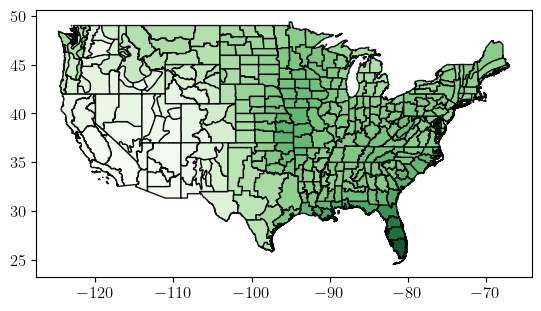

In [11]:
var = 'pcpn_june'
val_array = np.empty(len(gdf))
val_array[:] = np.nan
for i,id in enumerate(historical_avg.index):
    idx = gdf.loc[gdf.CLIMDIV == id].index
    if len(idx) == 1:
        val_array[idx[0]] = historical_avg.loc[id, var]

gdf['val'] = val_array
gdf.plot(column='val', cmap='Greens', legend=False, edgecolor = 'black', alpha = 0.9)

<Axes: >

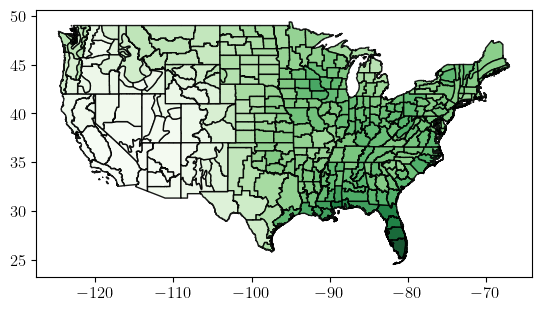

In [12]:
var = 'pcpn_june'
val_array = np.empty(len(gdf))
val_array[:] = np.nan
for i,id in enumerate(recent_avg.index):
    idx = gdf.loc[gdf.CLIMDIV == id].index
    if len(idx) == 1:
        val_array[idx[0]] = recent_avg.loc[id, var]
        
gdf['val'] = val_array
gdf.plot(column='val', cmap='Greens', legend=False, edgecolor = 'black', alpha = 0.9)

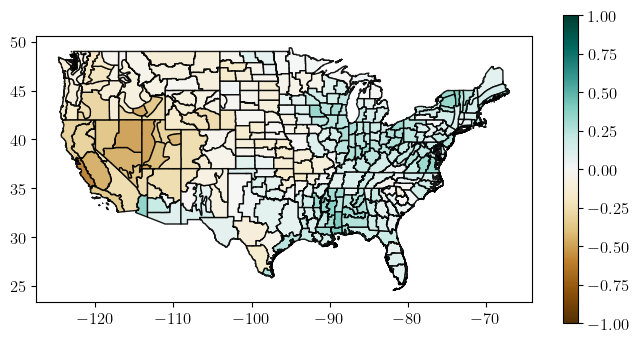

In [13]:
var = 'pcpn_june'
val_array = np.empty(len(gdf))
val_array[:] = np.nan
for i,id in enumerate(climate_change.index):
    idx = gdf.loc[gdf.CLIMDIV == id].index
    if len(idx) == 1:
        val_array[idx[0]] = climate_change.loc[id, var]
        
gdf['val'] = val_array

fig,ax = plt.subplots(figsize = (8,8))
gdf.plot(column='val', cmap='BrBG', ax = ax, vmin = -1, vmax = 1, legend=False, edgecolor = 'black', alpha = 0.9)
sm = plt.cm.ScalarMappable(cmap='BrBG', norm=plt.Normalize(vmin=-1, vmax=1))
sm._A = []
cbar = fig.colorbar(sm, ax=ax, shrink = 0.5)

# Clustering Baselines

In [14]:
data = climate_change.to_numpy()
feature_labels = climate_change.columns

## k-means

In [15]:
k_trials = list(range(2,41))
trial_scores = [-1]*len(k_trials)
for i,k in enumerate(k_trials):
    kmeans = KMeans(n_clusters=k, init = 'k-means++', n_init='auto', random_state = seed).fit(data)
    kmeans_clustering = labels_to_clustering(kmeans.labels_)
    trial_scores[i] = kmeans_cost(data, kmeans_clustering, kmeans.cluster_centers_)
    #trial_scores[i] = silhouette_score(data, kmeans.labels_)

Text(0, 0.5, 'Cost')

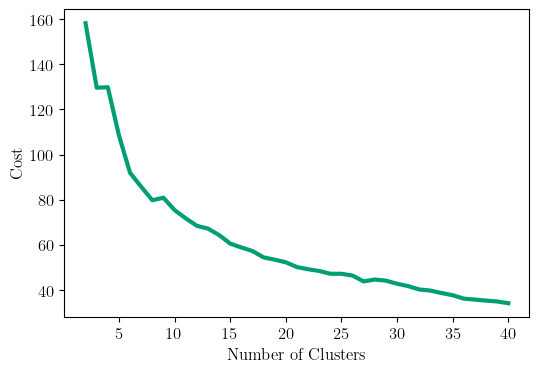

In [16]:
fig,ax = plt.subplots(figsize = (6,4))
ax.plot(k_trials, trial_scores, linewidth = 3, c = cmap(2))
ax.set_xlabel('Number of Clusters')
ax.set_ylabel('Cost')

In [17]:
k = 6
kmeans = KMeans(n_clusters=k, random_state=seed, n_init="auto").fit(data)

In [18]:
kmeans_clustering = labels_to_clustering(kmeans.labels_)
cost = kmeans_cost(data, kmeans_clustering, kmeans.cluster_centers_)

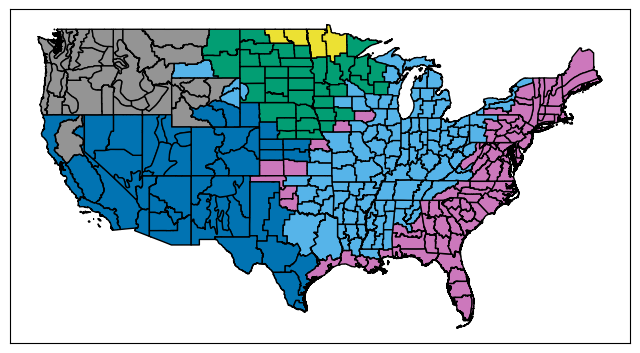

In [24]:
label_array = np.empty(len(gdf))
label_array[:] = np.nan
for i,id in enumerate(climate_change.index):
    idx = gdf.loc[gdf.CLIMDIV == id].index
    if len(idx) == 1:
        label_array[idx[0]] = kmeans.labels_[i]

gdf['cluster'] = label_array

fig,ax = plt.subplots(figsize=(8,8))
gdf.plot(column='cluster', cmap=cmap_subset2, ax = ax, legend=False, edgecolor = 'black', alpha = 1)

#legend_labels = np.unique(label_array)
#cmap = plt.get_cmap('tab20')
#norm = mcolors.Normalize(vmin=np.min(legend_labels), vmax=np.max(legend_labels))
#patches = [mpatches.Patch(color=cmap(norm(value)), label=f'cluster {int(value)}') for value in legend_labels]
#plt.legend(handles=patches, loc='upper left', bbox_to_anchor=(-0.2, 1), borderaxespad=0.)

plt.xticks([])
plt.yticks([]) 
plt.savefig('figures/climate_kmeans.jpg', bbox_inches = 'tight', dpi = 300)

### IMM

In [25]:
IMM_tree = ExTree(k, max_leaves = k, random_state = seed)
imm_labels = IMM_tree.fit_predict(data, kmeans)
imm_clustering = labels_to_clustering(imm_labels)
imm_centers = IMM_tree.all_centers
imm_cost = kmeans_cost(data, imm_clustering, imm_centers)

In [26]:
imm_cost

100.8187330069213

([], [])

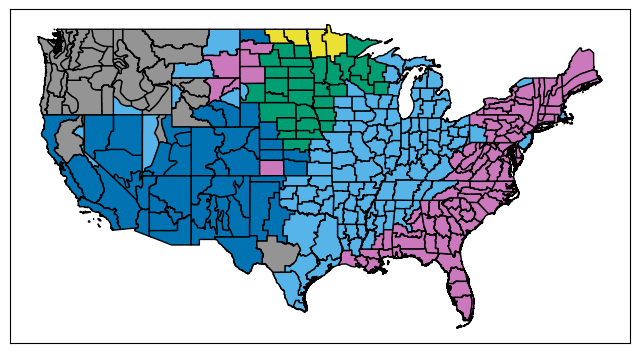

In [27]:
label_array = np.empty(len(gdf))
label_array[:] = np.nan
for i,id in enumerate(climate_change.index):
    idx = gdf.loc[gdf.CLIMDIV == id].index
    if len(idx) == 1:
        label_array[idx[0]] = imm_labels[i]

gdf['cluster'] = label_array

fig,ax = plt.subplots(figsize=(8,8))
gdf.plot(column='cluster', cmap=cmap_subset2, ax = ax, legend=False, edgecolor = 'black', alpha = 1)

#legend_labels = np.unique(label_array)
#cmap = plt.get_cmap('tab20')
#norm = mcolors.Normalize(vmin=np.min(legend_labels), vmax=np.max(legend_labels))
#patches = [mpatches.Patch(color=cmap(norm(value)), label=f'cluster {int(value)}') for value in legend_labels]
#plt.legend(handles=patches, loc='upper right', bbox_to_anchor=(1.2, 1), borderaxespad=0.)

plt.xticks([])
plt.yticks([]) 

In [28]:
converted_imm_tree = ConvertExKMC(IMM_tree.tree, data)

In [29]:
converted_imm_tree.depth

5

### ExKMC

In [31]:
ExKMC_tree = ExTree(k, max_leaves = k, base_tree = "NONE", random_state = seed)
exkmc_labels = ExKMC_tree.fit_predict(data, kmeans)
exkmc_clustering = labels_to_clustering(exkmc_labels)
exkmc_centers = ExKMC_tree.all_centers
exkmc_cost = kmeans_cost(data, exkmc_clustering, exkmc_centers)

([], [])

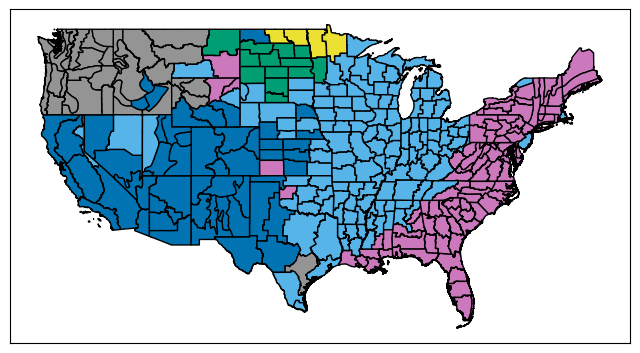

In [32]:
label_array = np.empty(len(gdf))
label_array[:] = np.nan
for i,id in enumerate(climate_change.index):
    idx = gdf.loc[gdf.CLIMDIV == id].index
    if len(idx) == 1:
        label_array[idx[0]] = exkmc_labels[i]

gdf['cluster'] = label_array

fig,ax = plt.subplots(figsize=(8,8))
gdf.plot(column='cluster', cmap=cmap_subset2, ax = ax, legend=False, edgecolor = 'black', alpha = 1)

#legend_labels = np.unique(label_array)
#cmap = plt.get_cmap('tab20')
#norm = mcolors.Normalize(vmin=np.min(legend_labels), vmax=np.max(legend_labels))
#patches = [mpatches.Patch(color=cmap(norm(value)), label=f'cluster {int(value)}') for value in legend_labels]
#plt.legend(handles=patches, loc='upper right', bbox_to_anchor=(1.2, 1), borderaxespad=0.)

plt.xticks([])
plt.yticks([]) 

In [34]:
#converted_exkmc_tree = ConvertExKMC(ExKMC_tree.tree, data)
#visualize_tree(converted_exkmc_tree.root, feature_labels = feature_labels)

### Random Tree

In [35]:
# Revert the seed in case it has been advanced anywhere else:
np.random.seed(seed)

random_tree_cost = np.inf
random_tree = None
random_tree_labels = None

for i in range(10000):
    random_tree_ = RandomTree(max_leaf_nodes = k, min_points_leaf = 1)
    random_tree_.fit(kmeans.cluster_centers_)
    random_tree_labels_ = random_tree_.predict(data)
    random_tree_clustering_ = labels_to_clustering(random_tree_labels_)
    random_tree_centers_ = np.vstack([data[cluster,:].mean(axis = 0) for cluster in random_tree_clustering_])
    #rcost = kmeans_cost(data, random_tree_clustering, kmeans.cluster_centers_)
    rcost = kmeans_cost(data, random_tree_clustering_, random_tree_centers_)
    if rcost < random_tree_cost:
        random_tree_cost = rcost
        random_tree = random_tree_
        random_tree_labels = random_tree_labels_

C:\Users\kq146\AppData\Local\Temp\ipykernel_22400\3266807905.py:13: RuntimeWarning: Mean of empty slice.
  random_tree_centers_ = np.vstack([data[cluster,:].mean(axis = 0) for cluster in random_tree_clustering_])
C:\Users\kq146\anaconda3\envs\ex_cluster\lib\site-packages\numpy\core\_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


In [36]:
random_tree_cost

106.96995185011676

([], [])

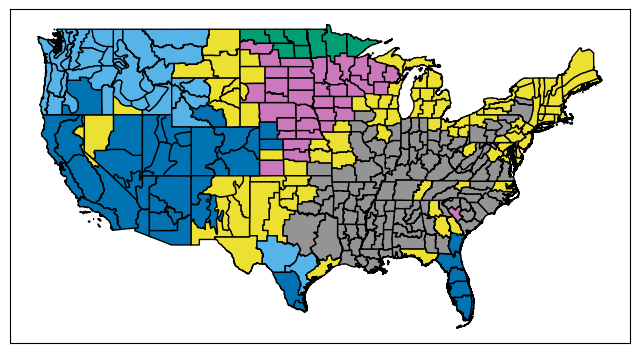

In [37]:
label_array = np.empty(len(gdf))
label_array[:] = np.nan
for i,id in enumerate(climate_change.index):
    idx = gdf.loc[gdf.CLIMDIV == id].index
    if len(idx) == 1:
        label_array[idx[0]] = random_tree_labels[i]

gdf['cluster'] = label_array

fig,ax = plt.subplots(figsize=(8,8))
gdf.plot(column='cluster', cmap=cmap_subset2, ax = ax, legend=False, edgecolor = 'black', alpha = 1)

#legend_labels = np.unique(label_array)
#cmap = plt.get_cmap('tab20')
#norm = mcolors.Normalize(vmin=np.min(legend_labels), vmax=np.max(legend_labels))
#patches = [mpatches.Patch(color=cmap(norm(value)), label=f'cluster {int(value)}') for value in legend_labels]
#plt.legend(handles=patches, loc='upper right', bbox_to_anchor=(1.2, 1), borderaxespad=0.)

plt.xticks([])
plt.yticks([]) 

## Rule Clustering

#### k-means Tree Partition

In [28]:
leaves = list(range(k,37))
cost_by_leaves = []
for l in leaves:
    kmeans_tree = KMeansTree(max_leaf_nodes = l, min_points_leaf = 1)
    kmeans_tree.fit(data)
    kmeans_rules = tree_to_rules().traverse(kmeans_tree.root)

    cost_sum = 0
    for r in kmeans_rules:
        r.fit(data)
        mu_r = np.mean(r.satisfied_points, axis = 0)
        cost_sum += np.sum((r.satisfied_points - mu_r)**2)

    cost_by_leaves.append(cost_sum)

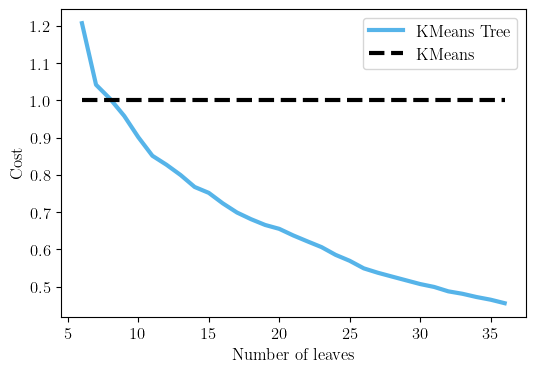

In [29]:
fig,ax = plt.subplots(figsize = (6,4))
plt.plot(leaves, np.array(cost_by_leaves)/cost, linewidth = 3, label = 'KMeans Tree', c = cmap(9))
plt.hlines(cost/cost, xmin = leaves[0], xmax = leaves[-1], color = 'k', linestyle = '--', label = 'KMeans', linewidth = 3)
plt.legend()
ax.set_xlabel('Number of leaves')
ax.set_ylabel('Cost')
plt.savefig('figures/tree_cost.jpg', bbox_inches = 'tight', dpi = 300)

In [30]:
rule_cluster_upper_bound = 4*cost + 6*np.array(cost_by_leaves)
imm_tree_upper_bound = k * (np.log(k)**2) * cost
random_tree_upper_bound = k**2 * cost

Text(0, 0.5, 'Cost')

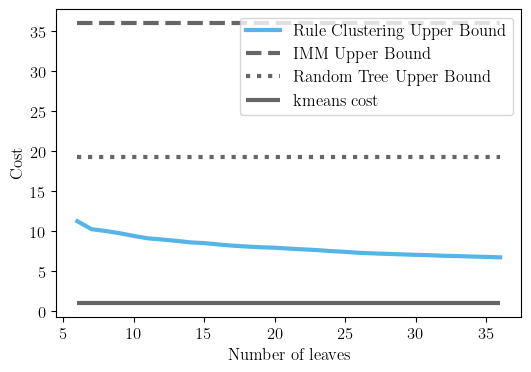

In [31]:
fig,ax = plt.subplots(figsize = (6,4))
plt.plot(leaves, rule_cluster_upper_bound/cost, linewidth = 3, label = 'Rule Clustering Upper Bound', c = cmap(9))
plt.hlines(random_tree_upper_bound/cost, xmin = leaves[0], xmax = leaves[-1], linestyle = '--', label = 'IMM Upper Bound', linewidth = 3, color = 'k', alpha = 0.6)
plt.hlines(imm_tree_upper_bound/cost, xmin = leaves[0], xmax = leaves[-1], linestyle = 'dotted', label = 'Random Tree Upper Bound', linewidth = 3, color = 'k', alpha = 0.6)
plt.hlines(cost/cost, xmin = leaves[0], xmax = leaves[-1], color = 'k', linestyle = '-', label = 'kmeans cost', linewidth = 3, alpha = 0.6)
plt.legend()
ax.set_xlabel('Number of leaves')
ax.set_ylabel('Cost')

#### Rule constrained k-means

In [38]:
k = 6

In [93]:
#max_leaves = 12
#rules = UnsupervisedTree(splits = 'axis', max_leaf_nodes = 12, norm = 2)
max_leaves = 6
rules = CentroidTree(splits = 'oblique', max_leaf_nodes = 6, norm = 2, center_init = 'manual', centers = kmeans.cluster_centers_)
rules.fit(data)

In [78]:
rules.depth

4

In [79]:
rule_kmeans = KMeansRuleClustering(rules, k_clusters = k, init = 'manual', center_init = kmeans.cluster_centers_, random_seed = seed)
rule_kmeans.fit(data)
rule_labels = rule_kmeans.labels
data_clustering, data_labels = rule_kmeans.predict(data, return_clustering = True)

In [80]:
imm_cost

100.8187330069213

In [81]:
rule_kmeans.cost

94.92045669701102

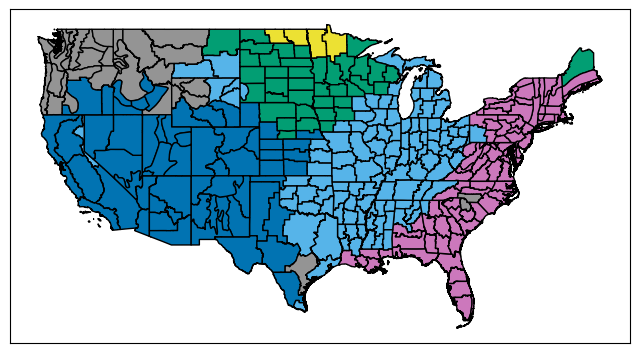

In [82]:
label_array = np.empty(len(gdf))
label_array[:] = np.nan
for i,id in enumerate(climate_change.index):
    idx = gdf.loc[gdf.CLIMDIV == id].index
    if len(idx) == 1:
        label_array[idx[0]] = data_labels[i]

gdf['cluster'] = label_array

fig,ax = plt.subplots(figsize=(8,8), dpi = 100)
gdf.plot(column='cluster', cmap=cmap_subset2, ax = ax, legend=False, edgecolor = 'black', alpha = 1)

#legend_labels = np.unique(label_array)
#cmap = plt.get_cmap('tab20')
#norm = mcolors.Normalize(vmin=np.min(legend_labels), vmax=np.max(legend_labels))
#patches = [mpatches.Patch(color=cmap(norm(value)), label=f'cluster {int(value)}') for value in legend_labels]
#plt.legend(handles=patches, loc='upper right', bbox_to_anchor=(1.2, 1), borderaxespad=0.)
plt.xticks([])
plt.yticks([]) 
plt.savefig('figures/climate_centroid_oblique.jpg', bbox_inches = 'tight', dpi = 300)

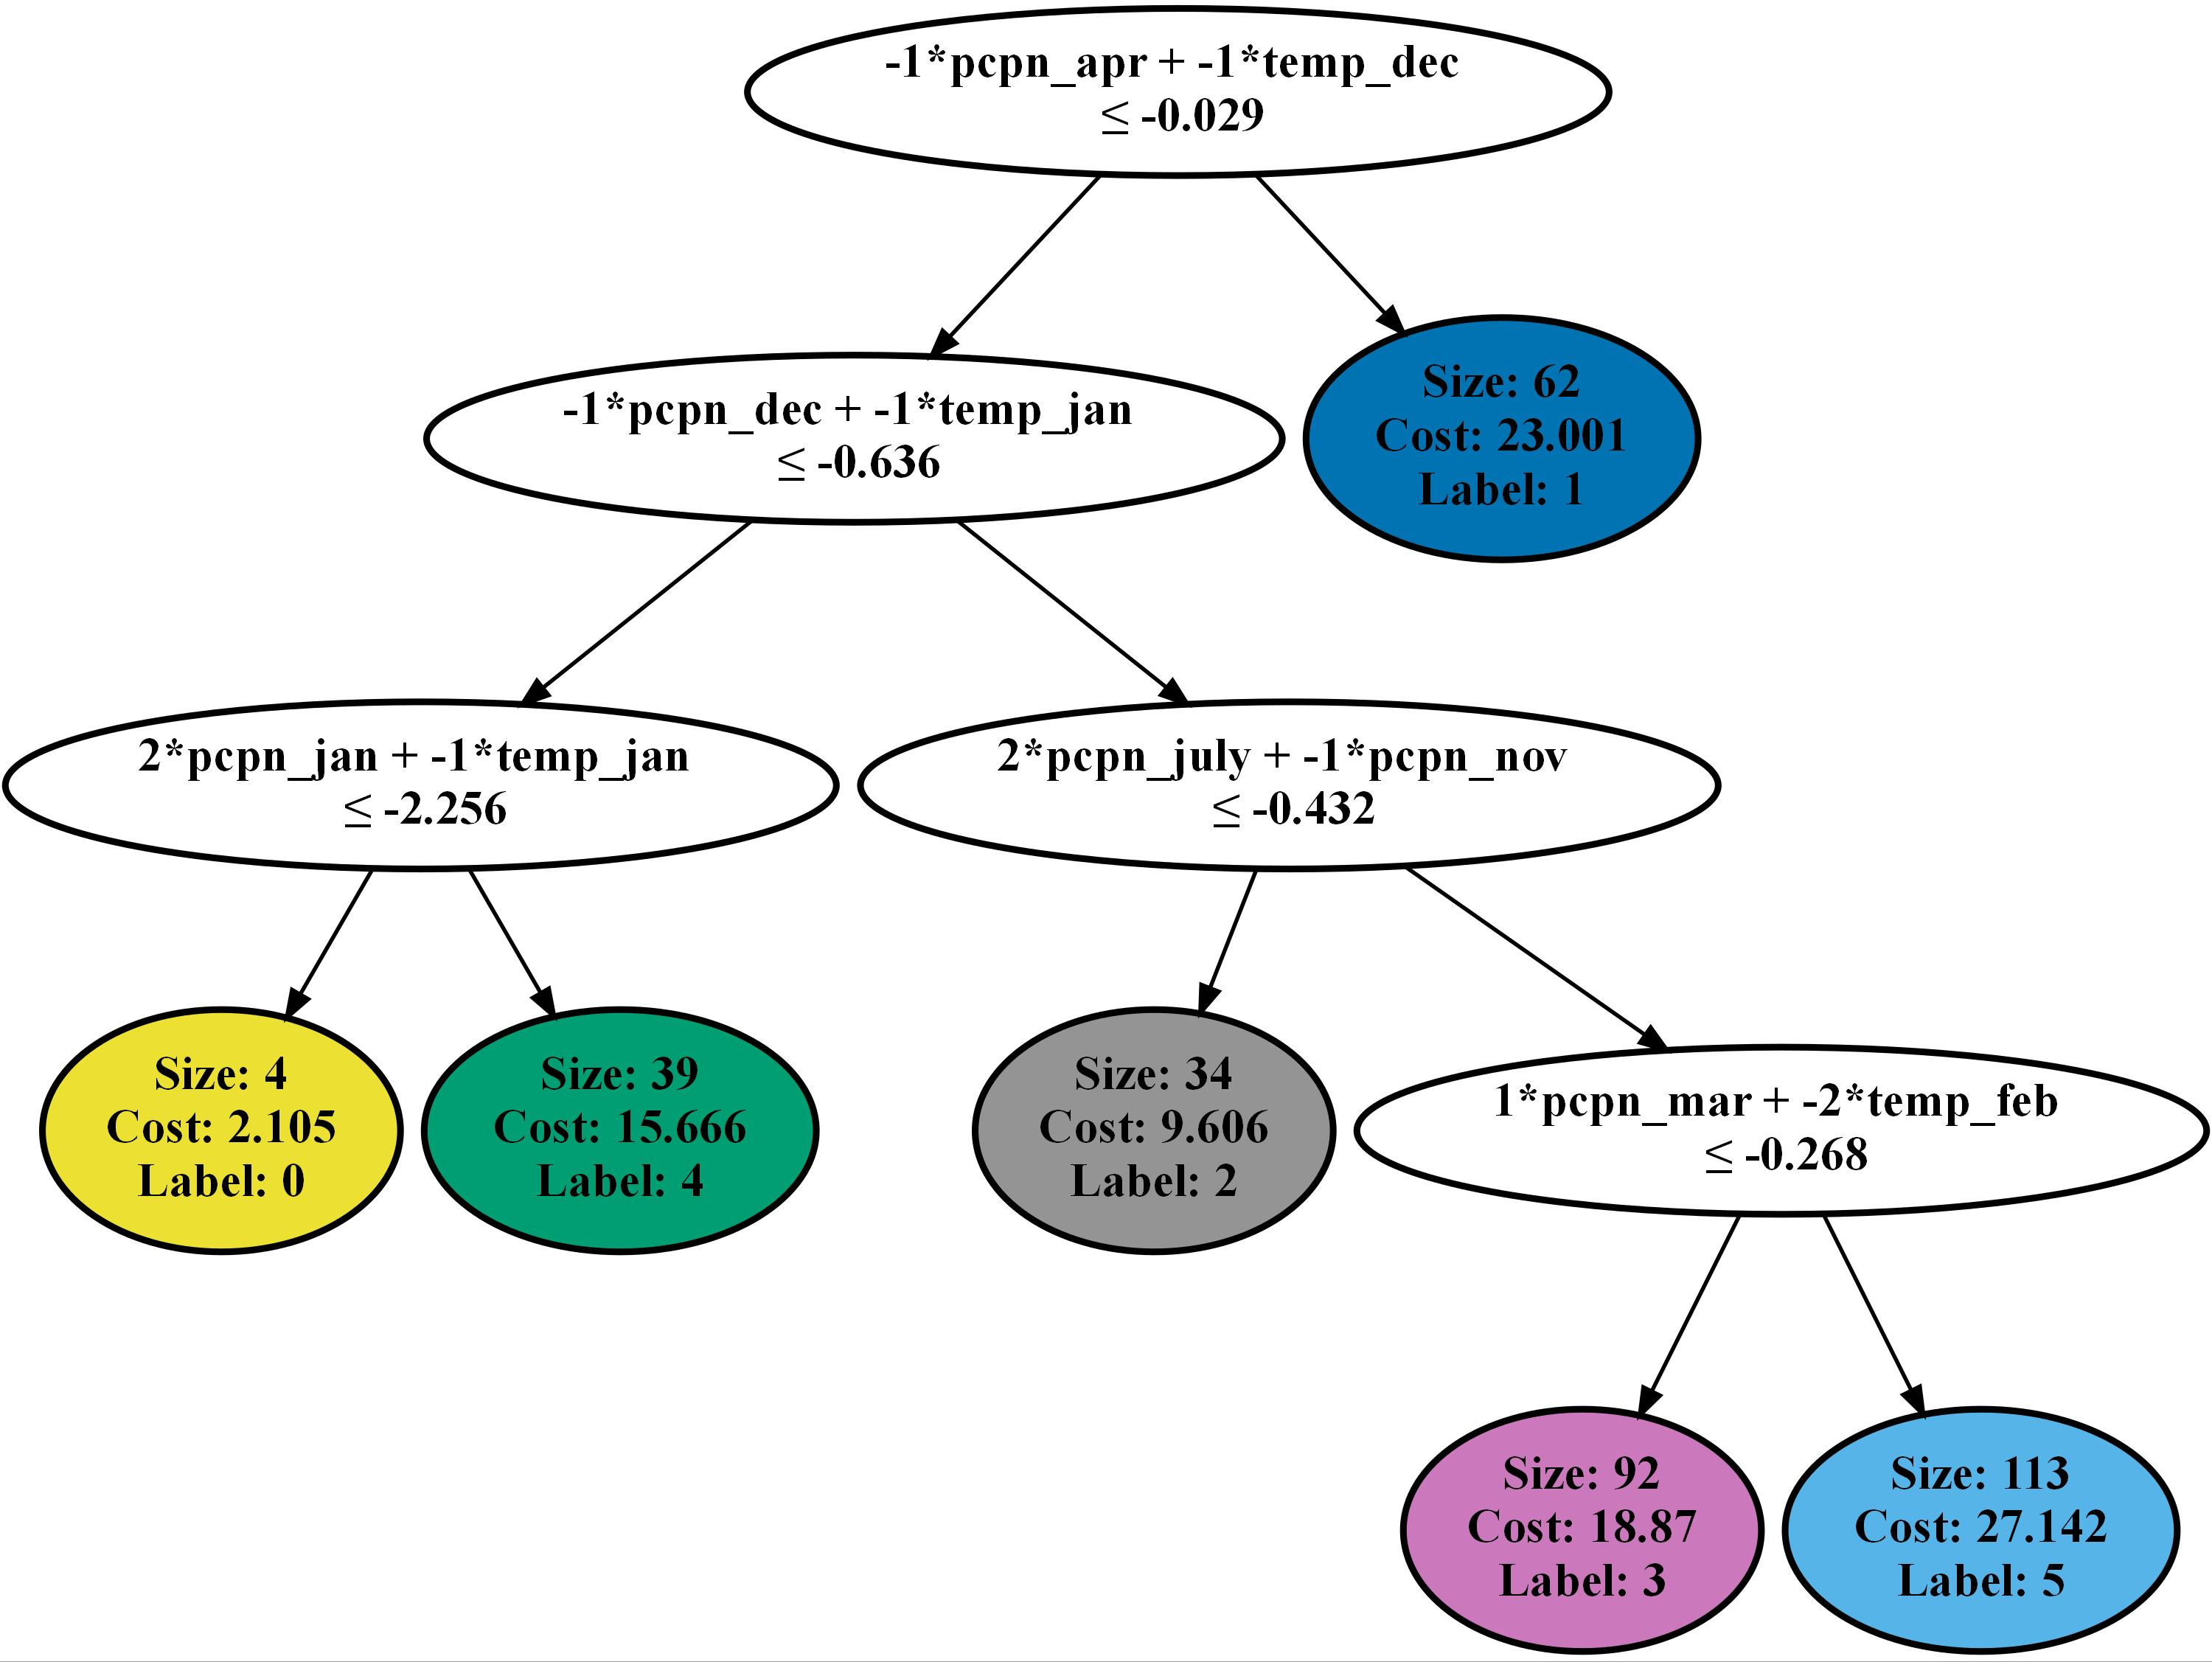

In [85]:
#leaf_node_labels = np.unique(range(12))
#leaf_colors = {leaf_node_labels[i]:mcolors.rgb2hex(cmap(int(rule_labels[i])), keep_alpha=True) for i in range(len(leaf_node_labels))}
leaf_colors = {i:mcolors.rgb2hex(cmap_subset2(int(rule_labels[i]))) for i in range(max_leaves)}
visualize_tree(rules.root, output_file = 'figures/centroid_oblique_tree.jpg', feature_labels = feature_labels, leaf_colors = leaf_colors)

### Cost-Interpretability Tradeoff

In [86]:
# LEAVES 

# Revert the seed in case it has been advanced anywhere else:
np.random.seed(seed)

# Random centers to use:
plus_plus_centers = kmeans_plus_plus_initialization(data, k)

# Rule Clustering algorithm to use:
Clusterer = KMeansRuleClustering

min_leaves = k
max_leaves = 32
leaves = list(range(min_leaves,max_leaves + 1))

# Define some models to be iteratively built (instead of re-computing them from scratch every iteration)
unsupervised_tree_ = UnsupervisedTree(splits = 'axis', max_leaf_nodes = max_leaves, norm = 2)
# Here we initialize a tree, which will expand later
unsupervised_tree_.fit(data, iterative = True, init_steps = k - 1)

unsupervised_oblique_tree_ = UnsupervisedTree(splits = 'oblique', max_leaf_nodes = max_leaves, norm = 2)
unsupervised_oblique_tree_.fit(data, iterative = True, init_steps = k - 1)

# This should be equivalent to ExKMC (if ExKMC doesn't use IMM base)
centroid_tree_ = CentroidTree(splits = 'axis', max_leaf_nodes = max_leaves, norm = 2, center_init = 'manual', centers = kmeans.cluster_centers_)
centroid_tree_.fit(data, iterative = True, init_steps = k - 1)

centroid_oblique_tree_ = CentroidTree(splits = 'oblique', max_leaf_nodes = max_leaves, norm = 2, center_init = 'manual', centers = kmeans.cluster_centers_)
centroid_oblique_tree_.fit(data, iterative = True, init_steps = k - 1)


clustered_tree_ = RuleClusteredTree(splits = 'axis', max_leaf_nodes = max_leaves, norm = 2, center_init = 'manual', centers = kmeans.cluster_centers_,
                                   clusterer = Clusterer, start_centers = kmeans.cluster_centers_)
clustered_tree_.fit(data, iterative = True, init_steps = k - 1)


clustered_oblique_tree_ = RuleClusteredTree(splits = 'oblique', max_leaf_nodes = max_leaves, norm = 2, center_init = 'manual', centers = kmeans.cluster_centers_,
                                   clusterer = Clusterer, start_centers = kmeans.cluster_centers_)
clustered_oblique_tree_.fit(data, iterative = True, init_steps = k - 1)



# Track cost by leaves:
exkmc_costs = []
rule_exkmc_costs = []
rule_cart_costs =[]
rule_unsupervised_costs = []
rule_unsupervised_oblique_costs = []
rule_centroid_costs = []
rule_centroid_oblique_costs = []
rule_clustered_costs = []
rule_clustered_oblique_costs = []

exkmc_depths = []
rule_exkmc_depths = []
rule_cart_depths =[]
rule_unsupervised_depths = []
rule_unsupervised_oblique_depths = []
rule_centroid_depths = []
rule_centroid_oblique_depths = []
rule_clustered_depths = []
rule_clustered_oblique_depths = []

# Expand the trees and compute cost:
for l in leaves:
    print("iteration: " + str(l))

    # ExKMC
    ExKMC_tree_ = ExTree(k, max_leaves = l, base_tree = "IMM")
    exkmc_labs_ = ExKMC_tree_.fit_predict(data, kmeans)
    exkmc_clustering_ = labels_to_clustering(exkmc_labs_)
    exkmc_centers_ = ExKMC_tree_.all_centers
    exkmc_cost_ = kmeans_cost(data, exkmc_clustering_, exkmc_centers_)
    exkmc_costs.append(exkmc_cost_)
    exkmc_depths.append(ExKMC_tree_._max_depth())

    # Rule ExKMC
    #exkmc_tree_ = ConvertExKMC(ExKMC_tree_.tree, data)
    #rule_exkmc_ = Clusterer(exkmc_tree_, k_clusters = k, init = 'manual', center_init = kmeans.cluster_centers_,)
    #rule_exkmc_.fit(data)
    #data_clustering_exkmc_, data_labels_exkmc_ = rule_exkmc_.predict(data, return_clustering = True)
    #rule_exkmc_costs.append(rule_exkmc_.cost)
    #rule_exkmc_depths.append(exkmc_tree_.depth)
    #rule_exkmc_iterations.append(rule_exkmc_.iterations)
    
    # Rule CART:
    kmeans_extend_ = KMeans(n_clusters=k, random_state=seed).fit(data)
    dtree_ = DecisionTreeClassifier(criterion='entropy', max_leaf_nodes = l)
    dtree_.fit(data, kmeans_extend_.labels_)
    cart_tree_ = ConvertSklearn(dtree_.tree_, data)

    rule_cart_ = Clusterer(cart_tree_, k_clusters = k, init = 'manual', center_init = kmeans.cluster_centers_)
    rule_cart_.fit(data)
    rule_cart_costs.append(rule_cart_.cost)
    rule_cart_depths.append(cart_tree_.depth)
    #rule_cart_iterations.append(rule_cart_.iterations)

    # Rule Clustering for Unsupervised Tree
    unsupervised_tree_.fit_step()
    rule_kmeans_ = Clusterer(unsupervised_tree_, k_clusters = k, init = 'manual', center_init = kmeans.cluster_centers_, random_seed = seed)
    rule_kmeans_.fit(data, fit_rules = False)
    rule_unsupervised_costs.append(rule_kmeans_.cost)
    rule_unsupervised_depths.append(unsupervised_tree_.depth)
    #rule_kmeans_iterations.append(rule_kmeans_.iterations)

    # Rule Clustering for Unsupervised Oblique Tree
    unsupervised_oblique_tree_.fit_step()
    rule_kmeans_ = Clusterer(unsupervised_oblique_tree_, k_clusters = k, init = 'manual', center_init = kmeans.cluster_centers_, random_seed = seed)
    rule_kmeans_.fit(data, fit_rules = False)
    rule_unsupervised_oblique_costs.append(rule_kmeans_.cost)
    rule_unsupervised_oblique_depths.append(unsupervised_oblique_tree_.depth)
    #rule_kmeans_iterations.append(rule_kmeans_.iterations)

    # Rule Clustering for Centroid Tree
    centroid_tree_.fit_step()
    rule_kmeans_ = Clusterer(centroid_tree_, k_clusters = k, init = 'manual', center_init = kmeans.cluster_centers_, random_seed = seed)
    rule_kmeans_.fit(data, fit_rules = False)
    rule_centroid_costs.append(rule_kmeans_.cost)
    rule_centroid_depths.append(centroid_tree_.depth)
    #rule_kmeans_iterations.append(rule_kmeans_.iterations)

    # Rule Clustering for Centroid Oblique Tree
    centroid_oblique_tree_.fit_step()
    rule_kmeans_ = Clusterer(centroid_oblique_tree_, k_clusters = k, init = 'manual', center_init = kmeans.cluster_centers_, random_seed = seed)
    rule_kmeans_.fit(data, fit_rules = False)
    rule_centroid_oblique_costs.append(rule_kmeans_.cost)
    rule_centroid_oblique_depths.append(centroid_oblique_tree_.depth)
    #rule_kmeans_iterations.append(rule_kmeans_.iterations)
    
    # Clustered Tree
    clustered_tree_.fit_step()
    #rule_kmeans_ = Clusterer(clustered_tree_, k_clusters = k, init = 'manual', center_init = clustered_tree_.centers, random_seed = seed)
    #rule_kmeans_.fit(data, fit_rules = False)
    #rule_clustered_costs.append(rule_kmeans_.cost)
    rule_clustered_costs.append(clustered_tree_.clustering_cost)
    rule_clustered_depths.append(clustered_tree_.depth)
    #rule_kmeans_iterations.append(rule_kmeans_.iterations)

    # Clustered Oblique Tree
    clustered_oblique_tree_.fit_step()
    rule_clustered_oblique_costs.append(clustered_oblique_tree_.clustering_cost)
    rule_clustered_oblique_depths.append(clustered_oblique_tree_.depth)
    #rule_kmeans_iterations.append(rule_kmeans_.iterations)

iteration: 6
iteration: 7
iteration: 8
iteration: 9
iteration: 10
iteration: 11
iteration: 12
iteration: 13
iteration: 14
iteration: 15
iteration: 16
iteration: 17
iteration: 18
iteration: 19
iteration: 20
iteration: 21
iteration: 22
iteration: 23
iteration: 24
iteration: 25
iteration: 26
iteration: 27
iteration: 28
iteration: 29
iteration: 30
iteration: 31
iteration: 32


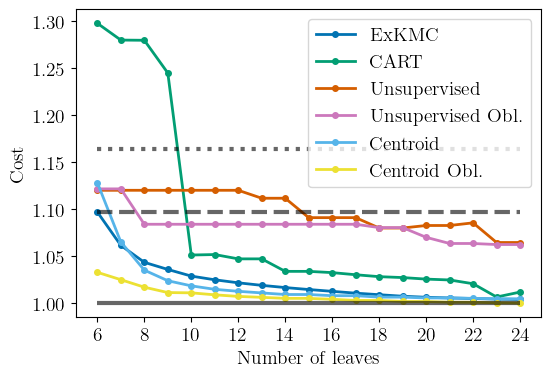

In [138]:
fig,ax = plt.subplots(figsize = (6,4))

ax.plot(leaves[:19], np.array(exkmc_costs[:19])/cost, linewidth = 2, marker='o', markersize = 4, label = 'ExKMC', c = cmap(0))
#ax.plot(leaves, np.array(rule_exkmc_costs)/cost, linewidth = 3, label = 'Rule ExKMC', c = cmap(1))
ax.plot(leaves[:19], np.array(rule_cart_costs[:19])/cost, linewidth = 2, marker='o', markersize = 4, label = 'CART', c = cmap(2))
ax.plot(leaves[:19], np.array(rule_unsupervised_costs[:19])/cost, linewidth = 2, marker='o', markersize = 4, label = 'Unsupervised', c = cmap(3))
ax.plot(leaves[:19], np.array(rule_unsupervised_oblique_costs[:19])/cost, linewidth = 2, marker='o', markersize = 4, label = 'Unsupervised Obl.', c = cmap(4))
ax.plot(leaves[:19], np.array(rule_centroid_costs[:19])/cost, linewidth = 2, marker='o', markersize = 4, label = 'Centroid', c = cmap(9))
ax.plot(leaves[:19], np.array(rule_centroid_oblique_costs[:19])/cost, linewidth = 2, marker='o', markersize = 4, label = 'Centroid Obl.', c = cmap(8))
#ax.plot(leaves, np.array(rule_clustered_costs)/cost, linewidth = 2, marker='o', markersize = 4, label = 'Hybrid', c = cmap(9))
#ax.plot(leaves, np.array(rule_clustered_oblique_costs)/cost, linewidth = 2, marker='o', markersize = 4, label = 'Hybrid Obl.', c = cmap(8))

ax.hlines(random_tree_cost/cost, xmin = leaves[0], xmax = leaves[18], color = 'k', linestyle = 'dotted', linewidth = 3, alpha = 0.6)
ax.hlines(imm_cost/cost, xmin = leaves[0], xmax = leaves[18], color = 'k', linestyle = '--', linewidth = 3, alpha = 0.6)
ax.hlines(cost/cost, xmin = leaves[0], xmax = leaves[18], color = 'k', linestyle = '-', linewidth = 3, alpha = 0.6)

plt.xticks(leaves[:19:2])
plt.legend(loc = 'upper right')
ax.set_xlabel('Number of leaves')
ax.set_ylabel('Cost')
plt.savefig('figures/leaves_cost_compare.jpg', bbox_inches = 'tight', dpi = 300)

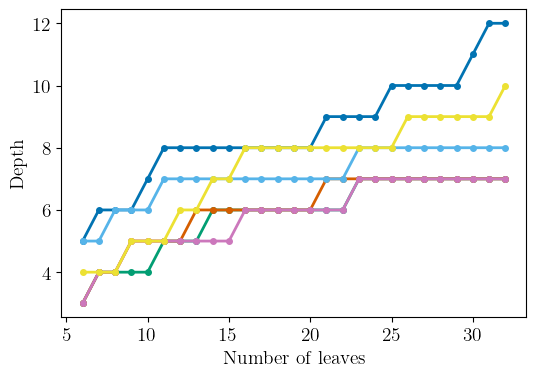

In [145]:
fig,ax = plt.subplots(figsize = (6,4))

ax.plot(leaves, exkmc_depths, linewidth = 2, marker='o', markersize = 4, label = 'ExKMC', c = cmap(0))
ax.plot(leaves, rule_cart_depths, linewidth = 2, marker='o', markersize = 4, label = 'Rule CART', c = cmap(2))
ax.plot(leaves, rule_unsupervised_depths, linewidth = 2, marker='o', markersize = 4, label = 'Rule Unsupervised', c = cmap(3))
ax.plot(leaves, rule_unsupervised_oblique_depths, linewidth = 2, marker='o', markersize = 4, label = 'Rule Unsupervised OB', c = cmap(4))
ax.plot(leaves, rule_centroid_depths, linewidth = 2, marker='o', markersize = 4, label = 'Rule Centroid', c = cmap(9))
ax.plot(leaves, rule_centroid_oblique_depths, linewidth = 2, marker='o', markersize = 4, label = 'Rule Centroid OB', c = cmap(8))

#ax.hlines(random_tree_cost/cost, xmin = leaves[0], xmax = leaves[-1], color = 'k', linestyle = 'dotted', label = 'Random Tree', linewidth = 3, alpha = 0.6)
#ax.hlines(imm_cost/cost, xmin = leaves[0], xmax = leaves[-1], color = 'k', linestyle = '--', label = 'IMM Tree', linewidth = 3, alpha = 0.6)
#ax.hlines(cost/cost, xmin = leaves[0], xmax = leaves[-1], color = 'k', linestyle = '-', label = 'kmeans cost', linewidth = 3, alpha = 0.6)

#plt.legend(loc = 'upper left')
ax.set_xlabel('Number of leaves')
ax.set_ylabel('Depth')
plt.savefig('figures/leaves_depth_compare.jpg', bbox_inches = 'tight', dpi = 300)

In [88]:
# Depths:

# Revert the seed in case it has been advanced anywhere else:
np.random.seed(seed)

# Rule Clustering algorithm to use:
Clusterer = KMeansRuleClustering

min_leaves = k
max_leaves = 32

min_depth = 3
max_depth = 8
depths = list(range(min_depth,max_depth + 1))


# Track cost by leaves:
rule_cart_costs2 =[]
rule_unsupervised_costs2 = []
rule_unsupervised_oblique_costs2 = []
rule_centroid_costs2 = []
rule_centroid_oblique_costs2 = []
rule_clustered_costs2 = []
rule_clustered_oblique_costs2 = []

# Expand the trees and compute cost:
for d in depths:
    print("iteration: " + str(d))
    
    # Rule CART:
    kmeans_extend_ = KMeans(n_clusters=k, random_state=seed).fit(data)
    dtree_ = DecisionTreeClassifier(criterion='entropy', max_leaf_nodes = l, max_depth = d)
    dtree_.fit(data, kmeans_extend_.labels_)
    cart_tree_ = ConvertSklearn(dtree_.tree_, data)

    rule_cart_ = Clusterer(cart_tree_, k_clusters = k, init = 'manual', center_init = kmeans.cluster_centers_)
    rule_cart_.fit(data)
    rule_cart_costs2.append(rule_cart_.cost)

    # Rule Clustering for Unsupervised Tree
    unsupervised_tree_ = UnsupervisedTree(splits = 'axis', max_leaf_nodes = max_leaves, max_depth = d, norm = 2)
    unsupervised_tree_.fit(data)
    rule_kmeans_ = Clusterer(unsupervised_tree_, k_clusters = k, init = 'manual', center_init = kmeans.cluster_centers_, random_seed = seed)
    rule_kmeans_.fit(data, fit_rules = False)
    rule_unsupervised_costs2.append(rule_kmeans_.cost)

    # Rule Clustering for Unsupervised Oblique Tree
    unsupervised_oblique_tree_ = UnsupervisedTree(splits = 'oblique', max_leaf_nodes = max_leaves, max_depth = d, norm = 2)
    unsupervised_oblique_tree_.fit(data)
    rule_kmeans_ = Clusterer(unsupervised_oblique_tree_, k_clusters = k, init = 'manual', center_init = kmeans.cluster_centers_, random_seed = seed)
    rule_kmeans_.fit(data, fit_rules = False)
    rule_unsupervised_oblique_costs2.append(rule_kmeans_.cost)

    # Rule Clustering for Centroid Tree
    centroid_tree_ = CentroidTree(splits = 'axis', max_leaf_nodes = max_leaves, max_depth = d, norm = 2, center_init = 'manual', centers = kmeans.cluster_centers_)
    centroid_tree_.fit(data)
    rule_kmeans_ = Clusterer(centroid_tree_, k_clusters = k, init = 'manual', center_init = centroid_tree_.centers, random_seed = seed)
    rule_kmeans_.fit(data, fit_rules = False)
    rule_centroid_costs2.append(rule_kmeans_.cost)

    # Rule Clustering for Centroid Oblique Tree
    centroid_oblique_tree_ = CentroidTree(splits = 'oblique', max_leaf_nodes = max_leaves, max_depth = d, norm = 2, center_init = 'manual', centers = kmeans.cluster_centers_)
    centroid_oblique_tree_.fit(data)
    rule_kmeans_ = Clusterer(centroid_oblique_tree_, k_clusters = k, init = 'manual', center_init = centroid_oblique_tree_.centers, random_seed = seed)
    rule_kmeans_.fit(data, fit_rules = False)
    rule_centroid_oblique_costs2.append(rule_kmeans_.cost)
    
    # Clustered Tree
    clustered_tree_ = RuleClusteredTree(splits = 'axis', max_leaf_nodes = max_leaves, max_depth = d, norm = 2, center_init = 'manual', centers = kmeans.cluster_centers_,
                                   clusterer = Clusterer, start_centers = kmeans.cluster_centers_)

    clustered_tree_.fit(data)
    rule_clustered_costs2.append(clustered_tree_.clustering_cost)

    # Clustered Oblique Tree
    clustered_oblique_tree_ = RuleClusteredTree(splits = 'oblique', max_leaf_nodes = max_leaves, max_depth = d, norm = 2, center_init = 'manual', centers = kmeans.cluster_centers_,
                                   clusterer = Clusterer, start_centers = kmeans.cluster_centers_)
    clustered_oblique_tree_.fit(data)
    rule_clustered_oblique_costs2.append(clustered_oblique_tree_.clustering_cost)

iteration: 3
iteration: 4
iteration: 5
iteration: 6
iteration: 7
iteration: 8


Text(0, 0.5, 'Cost')

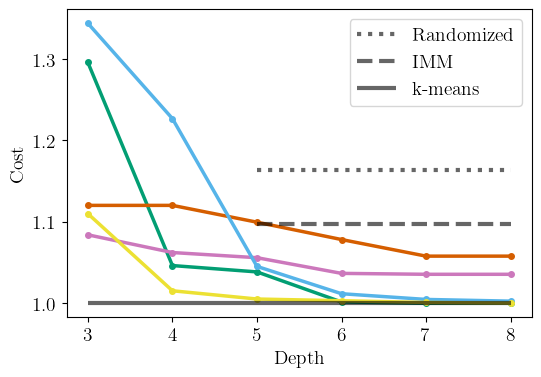

In [147]:
fig,ax = plt.subplots(figsize = (6,4))

ax.plot(depths, np.array(rule_cart_costs2)/cost, linewidth = 2.5, marker='o', markersize = 4, c = cmap(2))
ax.plot(depths, np.array(rule_unsupervised_costs2)/cost, linewidth = 2.5, marker='o', markersize = 4, c = cmap(3))
ax.plot(depths, np.array(rule_unsupervised_oblique_costs2)/cost, linewidth = 2.5, marker='o', markersize = 4, c = cmap(4))
ax.plot(depths, np.array(rule_centroid_costs2)/cost, linewidth = 2.5, marker='o', markersize = 4, c = cmap(9))
ax.plot(depths, np.array(rule_centroid_oblique_costs2)/cost, linewidth = 2.5, marker='o', markersize = 4, c = cmap(8))

#ax.scatter(radnom_tree.depth, random_tree_cost/cost, color = 'k', alpha = 0.7, marker = 'V', s = 100, label = 'IMM')
#ax.scatter(converted_imm_tree.depth, imm_cost/cost, color = 'k', alpha = 0.7, marker = '^', s = 100, label = 'IMM')
ax.hlines(random_tree_cost/cost, xmin = random_tree.depth, xmax = depths[-1], color = 'k', linestyle = 'dotted', label = 'Randomized', linewidth = 3, alpha = 0.6)
ax.hlines(imm_cost/cost, xmin = converted_imm_tree.depth, xmax = depths[-1], color = 'k', linestyle = '--', label = 'IMM', linewidth = 3, alpha = 0.6)
ax.hlines(cost/cost, xmin = depths[0], xmax = depths[-1], color = 'k', linestyle = '-', label = 'k-means', linewidth = 3, alpha = 0.6)

plt.legend(loc = 'upper right')
ax.set_xlabel('Depth')
ax.set_ylabel('Cost')
#plt.savefig('figures/depth_cost_compare.jpg', bbox_inches = 'tight', dpi = 300)

In [150]:
column_names1 = ['ExKMC', 'CART', 'Unsupervised', 'Unsupervised Obl.', 'Centroid', 'Centroid Obl.']

data_frame1 = {
    'ExKMC': exkmc_costs,
    'CART': rule_cart_costs,
    'Unsupervised': rule_unsupervised_costs,
    'Unsupervised Obl.': rule_unsupervised_oblique_costs,
    'Centroid': rule_centroid_costs,
    'Centroid Obl.': rule_centroid_oblique_costs
}

data_frame2 = {
    'CART': rule_cart_costs2,
    'Unsupervised': rule_unsupervised_costs2,
    'Unsupervised Obl.': rule_unsupervised_oblique_costs2,
    'Centroid': rule_centroid_costs2,
    'Centroid Obl.': rule_centroid_oblique_costs2
}

leaf_cost_df = pd.DataFrame(data_frame1)
depth_cost_df = pd.DataFrame(data_frame2)

leaf_cost_df.to_csv('../data/climate_leaf_costs.csv')
depth_cost_df.to_csv('../data/climate_depth_costs.csv')